In [24]:
#####################
# Helper functions - general
#####################
import re
def extract_file_number(f):
    # assuming xxx_Pos<number>.yyy
    f2 = f.split('Pos')[1].split('.')[0]
    s = re.findall("\d+$",f2)
    return (int(s[0]) if s else -1,f)

def get_comp_data(data,point,rad_size):
    return np.average(data[:,point[0]-rad_size:point[0]+rad_size,point[1]-rad_size:point[1]+rad_size],axis=(1,2))

def get_images(path):
    from os import listdir
    from os.path import isfile, join
    file_list= [f for f in listdir(path) if (isfile(join(path, f)) and 'Pos' in f)]
    if len(file_list)<1:
        print('ERROR: No files found in %s'%path)
    else:
        print('Found %d images'%len(file_list))
    return sorted( file_list,key=extract_file_number)

import json
import exifread
import numpy as np
import tifffile as tiff
def get_microscope_stage_pos(path,scale=0.912,deg = 0):
    with open(path, 'rb') as f:
        tags= exifread.process_file(f)  
        d = json.loads(tags['Image Tag 0xC7B3'].values)
    pos = np.array([d['YPositionUm'],-d['XPositionUm']])
    # rotate
    theta = np.radians(deg)
    c, s = np.cos(theta), np.sin(theta)
    R = np.matrix([[c, -s], [s, c]])
    pos = np.dot(R,pos.T).T
    pos = np.squeeze(np.asarray(np.round(pos*scale))) #+np.multiply(I_shape,0.5)
    return pos

def get_circ_centers(file_path,flipx = False,flipy=True):
    with open(file_path,'r') as f:
        lines = f.readlines()
        points = np.zeros((len(lines)-1,2))
        for i,line in enumerate(lines[1:]):
            l = line.split(',')
            points[i] = np.array([float(l[1]),float(l[0])])
            if (flipy):
                points[i,0] = -points[i,0]
            if (flipx):
                points[i,1] = -points[i,1]
    print ('extracted %d comprtments from csv file'%(len(points)))
    return points

def get_tl_br_comp(comp_list):
    ''' return index of top left, bottom right compartment in a list
    '''
    comp_diag_vec = np.array( [pos[0]+pos[1] for pos in comp_list])
    return [np.argmin(comp_diag_vec),np.argmax(comp_diag_vec)]
       

def affine_unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def affine_angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::"""
    v1_u = affine_unit_vector(v1)
    v2_u = affine_unit_vector(v2)
    r =  np.math.atan2(np.linalg.det([v1_u,v2_u]),np.dot(v1_u,v2_u))
    cosr = np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)
    sinr = -np.linalg.det([v1_u,v2_u])
    return r, cosr ,sinr

def affine_get_transform(src,tgt):
    tt = -np.mean(src,axis = 0)
    t  = np.mean(tgt,axis = 0)
    s = np.linalg.norm(tgt[1]-tgt[0])/np.linalg.norm(src[1]-src[0])
    r, cosr ,sinr = affine_angle_between(src[0]-src[1],tgt[0]-tgt[1])
    print('-------transform -------------------')
    print ('scale: %.6f, rotation: %.4f[deg]'%(s,180*r/np.pi))
    print ('src translations: ' + format(tt))
    print ('tgt translations: ' + format(t))
    print('------------------------------------')
    A2 = np.matrix([[s*cosr,-s*sinr,s*(tt[0]*cosr-tt[1]*sinr)+t[0]],
                    [s*sinr, s*cosr,s*(tt[0]*sinr+tt[1]*cosr)+t[1]],
                    [0     ,0      ,1                             ]])
    return lambda x: np.asarray((A2*np.vstack((np.matrix(x).reshape(2,1),1)))[0:2,:]).flatten()


class Markers:
    ''' define reference image and location in pixel for the compatments
    '''
    def __init__(self,m1_img_num,m1_col,m1_row,m2_img_num,m2_col,m2_row,m1_comp_num,m2_comp_num):
        self.m1_img_pos = np.array([m1_col,m1_row])
        self.m2_img_pos = np.array([m2_col,m2_row])
        self.m1_img_num = m1_img_num
        self.m2_img_num = m2_img_num
        self.m1_comp_num = m1_comp_num
        self.m2_comp_num = m2_comp_num

In [101]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

class DataGrabber:
    ''' get all compartments data from an experiment using a compartment position file'''
    def __init__(self,preview_path,data_path,out_path,design_csv_path,stage_deg=0.,mirrored=False,markers=None):
        self.preview_path = preview_path
        self.data_path = data_path
        self.out_path = out_path
        self.img_list = get_images(self.preview_path)
        self.img_stage_pos = [get_microscope_stage_pos(preview_path+x,deg=stage_deg) for x in self.img_list]
        self.comp_loc_autocad = get_circ_centers(design_csv_path,flipx=mirrored)       
        self.resolution = np.array([1080,1280])
        # create output folder:
        import pathlib
        pathlib.Path(out_path).mkdir(parents=True, exist_ok=True) 
        if markers:
            self.set_design_markers(markers)
        
    def set_design_markers(self,markers,plot_comp_map=False):
        '''
        shows on which compartments user needs to align.
        user can enter compartment numbers manually by: .show_alignment_comp([<compartment number 1>,<compartment number 2>])
        '''
        self.markers = markers
        m1_pos = self.comp_loc_autocad[markers.m1_comp_num]
        m2_pos = self.comp_loc_autocad[markers.m2_comp_num] 
        # for alignment usage
        self.design_markers = np.empty((2,2))
        self.design_markers[0] = np.array([m1_pos[0],m1_pos[1]])
        self.design_markers[1] = np.array([m2_pos[0],m2_pos[1]])
        
        if plot_comp_map:
            import matplotlib.pyplot as plt
            f,ax=plt.subplots(1,1,figsize=(15,5))
            y = [-x[0] for x in self.comp_loc_autocad]
            x = [x[1] for x in self.comp_loc_autocad]
            ax.scatter(x,y)
            ax.annotate('Marker 1', (m1_pos[1], -m1_pos[0]))
            ax.annotate('Marker 2', (m2_pos[1], -m2_pos[0]))
            ax.scatter([m1_pos[1],m2_pos[1]],[-m1_pos[0],-m2_pos[0]])
        print('[DataGrabber] [info] Desgin markers set.')
    
    def compute_alignment(self):
        '''
        matches design file to microscope image set. assign compartments data to be exteacted from the closest image file
        '''
        img_markers = np.empty((2,2))
#         print(microscope_markers.m1_img_pos)
#         print(self.img_stage_pos[microscope_markers.m1_img_num])
        img_markers[0] = self.markers.m1_img_pos + self.img_stage_pos[self.markers.m1_img_num]
        img_markers[1] = self.markers.m2_img_pos + self.img_stage_pos[self.markers.m2_img_num]      
        self.transFn = affine_get_transform(self.design_markers,img_markers)
        self.proximity_mat = np.zeros((len(self.img_list),(self.comp_loc_autocad).shape[0]))
        self.comp_loc_microscope = np.apply_along_axis(self.transFn,1,self.comp_loc_autocad)
        
        for i in range(self.proximity_mat.shape[0]):
            #imges
            img_center = self.img_stage_pos[i]+self.resolution/2
            for j in range(self.proximity_mat.shape[1]):
                #compartments
                self.proximity_mat[i,j] = np.linalg.norm(self.comp_loc_microscope[j]-img_center) 
        self.comp_img_list = np.argmin(self.proximity_mat,axis=0)
    
    def show_comp_per_img(self):
        ''' Plot all compartments relative to the microscope images, assign different color for compartment that will be extracted from each image.
        '''
        f,ax=plt.subplots(1,1,figsize=(15,5))
        
        # compartment marking
        for i,comp in enumerate(self.comp_loc_microscope):
                scat = np.roll(comp-self.img_stage_pos[0],1)
                plt.scatter(comp[1],comp[0],c=cm.hsv(1.0/14*self.comp_img_list[i]),marker='o')
        
        # image center annotation
        y = [x[0]+self.resolution[0]/2 for x in self.img_stage_pos]
        x = [p[1]+self.resolution[1]/2 for p in self.img_stage_pos]
        for i,(xi,yi) in enumerate(zip(x,y)):
            ax.annotate(i, (xi, yi))
        ax.set_aspect('equal')
        plt.savefig(self.out_path+'colored_comp_per_img.png',dpi=150)
    
    def show_alignment(self,cols=4):
        img_num = len(self.img_list)
        rows = int(np.ceil((1.0*img_num)/cols))
        f,ax = plt.subplots(rows,cols,figsize=(cols*5,rows*5))
        for row in range(rows):
            for col in range(cols):
                curr_ax=ax[row][col]
                p = cols*row+col
                if p>=img_num: break
                pic = (tiff.imread(self.preview_path+self.img_list[p]))
                curr_ax.imshow(pic,'gray')
                for i,comp in enumerate(self.comp_loc_microscope):
                    if self.comp_img_list[i] == p:
                        scat = np.roll(comp-self.img_stage_pos[p],1)
                        curr_ax.scatter(scat[0],scat[1],c='r',marker='.')
                        curr_ax.annotate(i, (scat[0],scat[1]))

                if p ==  self.markers.m1_img_num:
                    print('m1 img_num %d, pos=[%d,%d]'%(p,self.markers.m1_img_pos[1],self.markers.m1_img_pos[0]))
                    curr_ax.scatter(self.markers.m1_img_pos[1],self.markers.m1_img_pos[0])
                elif p == self.markers.m2_img_num:
                    print('m2 img_num %d, pos=[%d,%d]'%(p,self.markers.m2_img_pos[1],self.markers.m2_img_pos[0]))
                    curr_ax.scatter(self.markers.m2_img_pos[1],self.markers.m2_img_pos[0])
                curr_ax.set_title('Pos %d'%p)
        plt.savefig(self.out_path+'image_compatrment_allocation.png',dpi=300)

        def get_data(self):
            print('not implemented')
            
        

# usage example (20/09/18 experiment)

Found 14 images
extracted 370 comprtments from csv file
[DataGrabber] [info] Desgin markers set.
-------transform -------------------
scale: 730.266531, rotation: -179.9561[deg]
src translations: [ 2.7685  0.6744]
tgt translations: [-1446.5 -7017. ]
------------------------------------
m1 img_num 0, pos=[1085,874]


C:\Users\omersha\Anaconda3\lib\site-packages\tifffile\tifffile.py:1770: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn("ome-xml: not an ome-tiff master file")


m2 img_num 13, pos=[400,318]


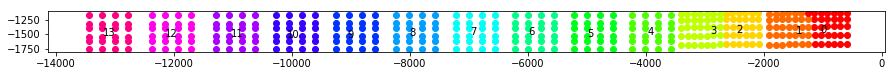

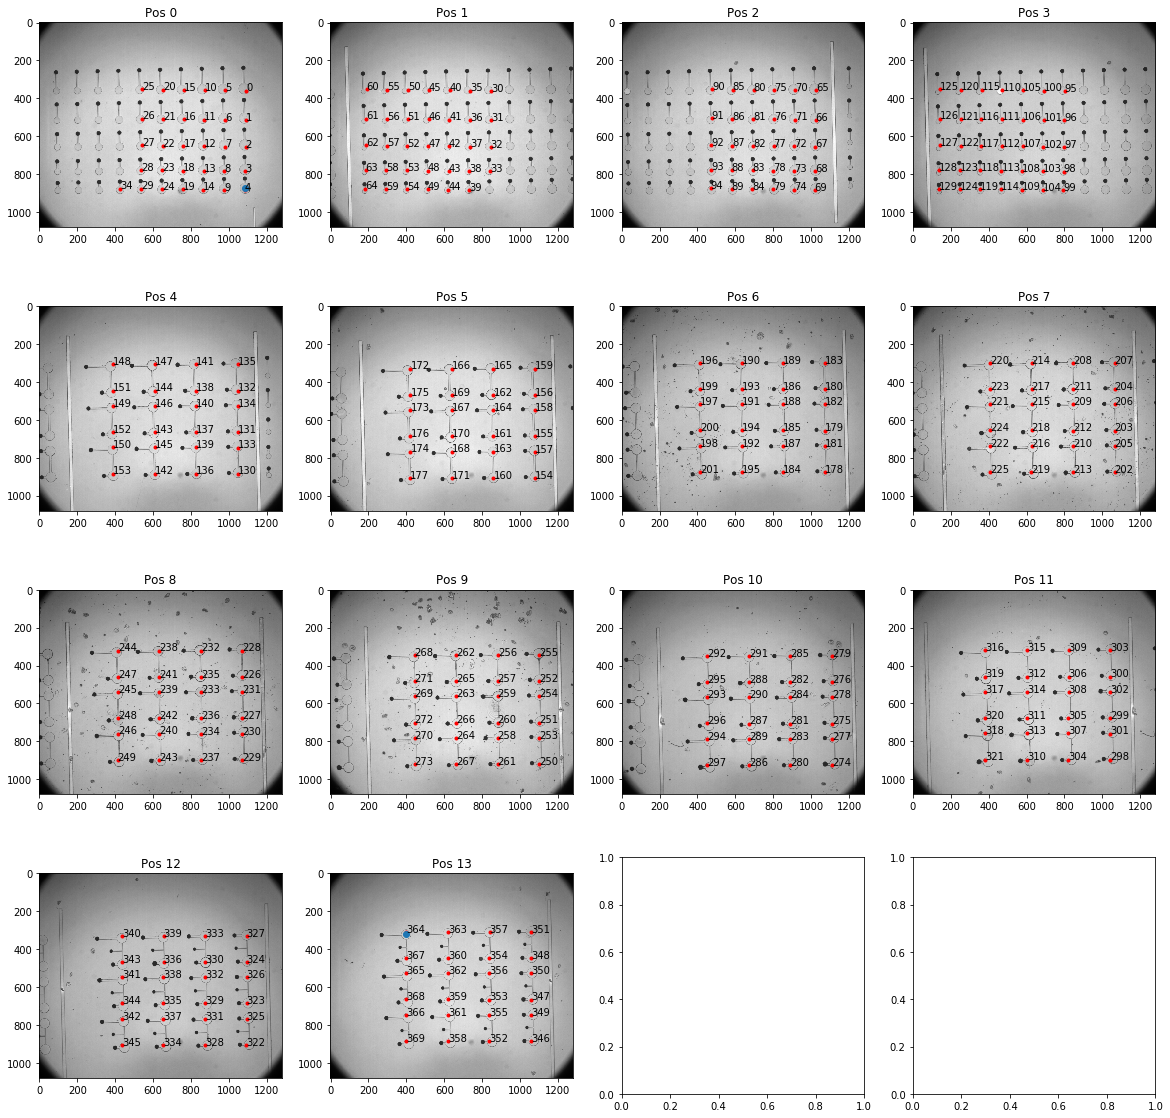

In [92]:
# test
%matplotlib inline
stage_deg = -1.28
d_g = DataGrabber(
    preview_path = 'C:\\Users\\omersha\\Desktop\\20180920\\bf 120ms 2X2 ndf1_1\\',
    data_path = 'C:\\Users\\omersha\\Desktop\\20180920\\exp 800ms 2X2 ndf2_1\\',
    out_path = 'C:\\Users\\omersha\\Desktop\\20180920\\auto_grab\\',
    design_csv_path = 'C:\\Users\\omersha\\Dropbox (Weizmann)\\omer_spotter\\rev43_28_6_18\\2d_rev4.3_DNA_all.csv',
    stage_deg=stage_deg
)

markers= Markers(0,874,1085,13,318,400,4,364)
d_g.set_design_markers(markers,plot_comp_map=False)
#markers= Markers(0,704,1075,-1,484,400) # minus rotation
#markers= Markers(0,650,1085,-1,550,400)

d_g.compute_alignment(markers)
d_g.show_comp_per_img()
d_g.show_alignment()


# example 2 (10/10/18 experiment)

Found 11 images
extracted 391 comprtments from csv file
[DataGrabber] [info] Desgin markers set.
-------transform -------------------
scale: 730.029761, rotation: -179.7581[deg]
src translations: [-11.6166   -0.40185]
tgt translations: [ 1667.5  6548. ]
------------------------------------
m2 img_num 0, pos=[277,800]


C:\Users\omersha\Anaconda3\lib\site-packages\tifffile\tifffile.py:1770: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn("ome-xml: not an ome-tiff master file")


m1 img_num 10, pos=[640,200]


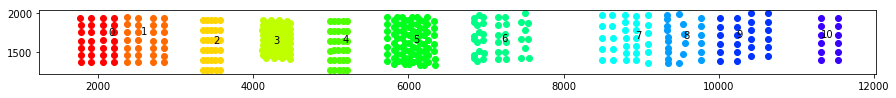

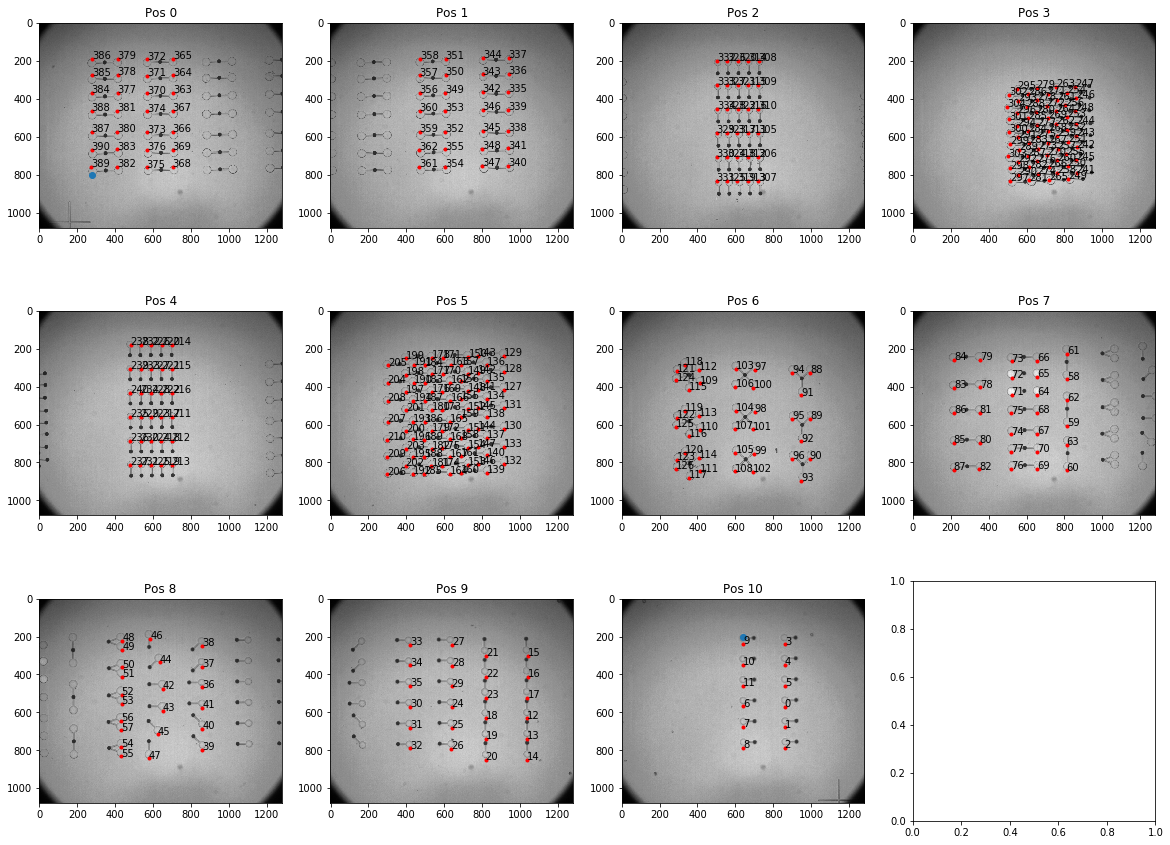

In [110]:
# test
%matplotlib inline
stage_deg2 = -.4 # 2.6

markers2= Markers(
    m1_img_num= 0,
    m1_col= 200,
    m1_row= 277,
    m2_img_num= 10,
    m2_col= 765,
    m2_row= 640,
    m1_comp_num= 386,
    m2_comp_num= 8 
)

path2 = 'C:\\Users\\omersha\\Desktop\\20181010\\'
d_g3 = DataGrabber(
    preview_path = path2+'bf_2x2_ndf2_200ms_1\\',
    data_path = 'C:\\Users\\omersha\\Desktop\\20180920\\exp 800ms 2X2 ndf2_1\\',
    out_path = path2+'auto_grab\\',
    design_csv_path = 'C:\\Users\\omersha\\Dropbox (Weizmann)\\omer_spotter\\JoshR\\20181010\\2D_JR_compartment_DNA_mirrored_1_sparse.csv',
    stage_deg=stage_deg2,
    markers=markers2
)
d_g3.compute_alignment()
d_g3.show_comp_per_img()
d_g3.show_alignment()

Found 11 images
extracted 391 comprtments from csv file
-------transform -------------------
scale: 729.941876, rotation: 179.5543[deg]
src translations: [-11.6315   -0.25185]
tgt translations: [ -577.  6658.]
------------------------------------


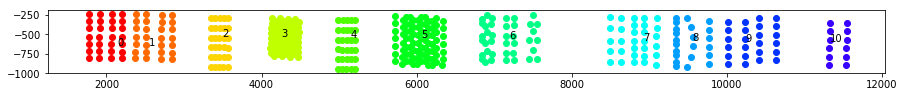

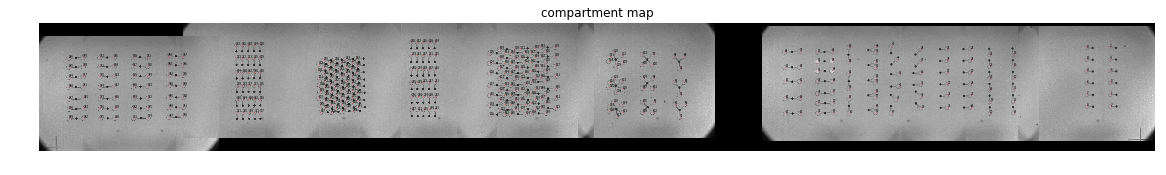

In [21]:
%matplotlib inline
# test 2
path2 = 'C:\\Users\\omersha\\Desktop\\20181010\\'
stage_deg = 0.3 # -2.65# 0.8
d_g2 = DataGrabber(
    img_path = path2+'bf_2x2_ndf2_200ms_1\\',
    out_path = path2+'auto_grab\\',
    design_csv_path = 'C:\\Users\\omersha\\Dropbox (Weizmann)\\omer_spotter\\JoshR\\20181010\\2D_JR_compartment_DNA_mirrored_1_sparse.csv',
    stage_deg=stage_deg,
    #mirrored=True
    mirrored=False
)
#markers2= Markers(0,301,277,10,859,856)
markers2= Markers(10,859,856,0,301,277)
d_g2.set_design_markers(plot_comp_map=False)

d_g2.compute_alignment(markers2)
d_g2.show_comp_per_img()
# d_g2.show_alignment()
import matplotlib as mpl
font = mpl.font_manager.FontProperties(family='Tahoma', size=3)
f,ax = plt.subplots(1,1,figsize=(20,10))
pic = tiff.imread(path2+'bf_combined.tif')[0]
ax.imshow(pic,'gray')
comp_shift = np.array([0, -55])
for i,comp in enumerate(d_g2.comp_loc_microscope):
    scat = np.roll(comp-d_g2.img_stage_pos[0],1)+comp_shift
    ax.scatter(scat[0],scat[1],c='r',marker='.',s=0.1)
    ax.annotate(i, (scat[0],scat[1]), fontproperties=font)
ax.set_title('compartment map')
plt.axis('off')
plt.savefig(path2+'bf_combined+comp_stage_deg_%.2f.png'%stage_deg,dpi=300)

